## Save mutation profiles (and other associated data) to files, and make some combined plots

For some reason, this notebook often causes the Jupyter Notebook kernel to fail -- closing other tabs in Chromium / applications running on my laptop seems to help...?

In [1]:
%run "ComputeUniMutationalFractions.ipynb"

In [2]:
from collections import defaultdict

def get_all_mutation_profile_data(
    seq,
    geneloc="/Poppy/mfedarko/sheep_metagenome/redo_work_big_nonhaplo_graph/prodigal_out"
):
    """Partially copied from get_mutation_profile(), but extended."""

    num_mutations_to_freq = defaultdict(int)
    num_mutations_to_fvals = defaultdict(list)
    num_mutations_to_avgf = defaultdict(int)
    num_mutations_to_unimutational_pos_ct = defaultdict(int)
    num_mutations_to_unimutational_pos_ct_frac = defaultdict(int)
    # Number of CP 1/2/3 and non-coding positions with N mutations
    # (You can think of these as sort of individual mutation profiles limited to specific "types" of
    # positions in a genome)
    num_mutations_to_cp1ct = defaultdict(int)
    num_mutations_to_cp2ct = defaultdict(int)
    num_mutations_to_cp3ct = defaultdict(int)
    num_mutations_to_ncpct = defaultdict(int)
    
    genes = parse_sco("{}/{}_genes.sco".format(geneloc, seq))
    # maps positions to a list of the CPs they are. (It's a list, and not just an integer, b/c of overlapping
    # genes -- a given position could be in CP 1 of one gene and CP 2 of an overlapping gene, for example...
    # we could also just filter positions shared in multiple genes, but the other analyses here don't do that
    # so for consistency's sake we continue to "double-count" positions sometimes)
    pos2cptypes = defaultdict(set)
    # TODO: abstract gene iteration to helper function; I've reused this code a lot in this notebook
    for gene in genes.itertuples():
        i = 1
        # (note that positions returned by get_pos_interval_from_gene() are ints, while seq2pos2...
        # stuff use string positions. This is wack and ideally should be made easier to work with)
        for pos in get_pos_interval_from_gene(gene):
            pos2cptypes[str(pos)].add(i)
            if i == 1: i = 2
            elif i == 2: i = 3
            elif i == 3: i = 1
            else: raise ValueError("Codon position modulo calculation is broken :|")
        if i != 1: raise ValueError("Gene length not divisible by 3")
    
    for pos in seq2pos2matchct[seq]:
        # ignore uncovered places. Could also ignore places with less than some threshold coverage
        # (e.g. 5) if desired
        if seq2pos2matchct[seq][pos] + seq2pos2mismatchct[seq][pos] == 0:
            continue
        
        # Most important part - figure out how many mutations this position has
        mutct = seq2pos2mismatchct[seq][pos]
        
        # Update frequency (main point of the mutation profile)
        num_mutations_to_freq[mutct] += 1
        # Update CP / non-coding pos cts
        cptypes = pos2cptypes[pos]
        if len(cptypes) == 0:
            num_mutations_to_ncpct[mutct] += 1
        else:
            # NOTE: This is an inelegant way of writing this - ideally these would all be one structure
            for cp in cptypes:
                if cp == 1: num_mutations_to_cp1ct[mutct] += 1
                elif cp == 2: num_mutations_to_cp2ct[mutct] += 1
                elif cp == 3: num_mutations_to_cp3ct[mutct] += 1
                else: raise ValueError("Unrecognized CP type")
                    
        if seq2pos2f[seq][pos] is None:
            # This means f is undefined because there are no alternate bases at this position.
            if mutct == 0:
                if len(seq2pos2mismatches[seq][pos]) > 0:
                    raise ValueError("uh oh")
                num_mutations_to_fvals[mutct].append(seq2pos2f[seq][pos])
            else:
                # Previously, this case could happen accidentally due to deletions messing with things. Now it
                # shouldn't ever happen.
                raise ValueError("Found undefined f at position {} in {} with alternate bases".format(pos, seq))
        else:
            num_mutations_to_fvals[mutct].append(seq2pos2f[seq][pos])
            if len(seq2pos2mismatches[seq][pos]) == 1:
                num_mutations_to_unimutational_pos_ct[mutct] += 1

    # Now that we've gone through all positions in this sequence, update some aggregate stats (avg.
    # uni-mutational fraction [aka average f-value]; fraction of uni-mutational positions).
    # Note that we iterate through this range - not just the keys of num_mutations_to_freq - because
    # we want to look over the places where there are 0 mutations, which are implicitly not included in
    # num_mutations_to_freq since it's a defaultdict
    for i in range(0, max(num_mutations_to_freq.keys()) + 1):
        if num_mutations_to_freq[i] > 0:
            if None in num_mutations_to_fvals[i]:
                if i == 0:
                    avg_f = "N/A"
                else:
                    raise ValueError("Something is bad")
            else:
                if len(num_mutations_to_fvals[i]) == 0:
                    raise ValueError("Something went horribly wrong... deletion error again?")
                else:
                    avg_f = sum(num_mutations_to_fvals[i]) / len(num_mutations_to_fvals[i])
        else:
            avg_f = "N/A"
        # I'm aware that the use of an underscore in "avg_f" should be more consistent; sorry ._.
        num_mutations_to_avgf[i] = avg_f

        # This is the fraction of positions with this many mutations which are uni-mutational.
        # So, 100% of positions with exactly one mutation are uni-mutational (so this is 1),
        # and so on. Of course, if there are 0 positions with a given number of mutations,
        # then we'd have to divide by 0 to compute this -- so we just call it "N/A" for these rows.
        if num_mutations_to_freq[i] > 0:
            num_mutations_to_unimutational_pos_ct_frac[i] = num_mutations_to_unimutational_pos_ct[i] / num_mutations_to_freq[i]
        else:
            num_mutations_to_unimutational_pos_ct_frac[i] = "N/A"
            
    data = {
        "num_mutations_to_freq": num_mutations_to_freq,
        "num_mutations_to_cp1ct": num_mutations_to_cp1ct,
        "num_mutations_to_cp2ct": num_mutations_to_cp2ct,
        "num_mutations_to_cp3ct": num_mutations_to_cp3ct,
        "num_mutations_to_ncpct": num_mutations_to_ncpct,
        "num_mutations_to_unimutational_pos_ct": num_mutations_to_unimutational_pos_ct,
        "num_mutations_to_unimutational_pos_ct_frac": num_mutations_to_unimutational_pos_ct_frac,
        "num_mutations_to_avg_unimutational_fraction": num_mutations_to_avgf,
    }
    return data

In [3]:
def save_mutation_profile(seq, output_dir="mutation-profiles"):
    data = get_all_mutation_profile_data(seq)

    out_fn = os.path.join(output_dir, "{}_mutation_profile.tsv".format(seq2name[seq]))
    with open(out_fn, "w") as tsvf:
        headerline = "\t".join((
            "Number of mutations",
            "Number of positions with this many mutations",
            "Number of CP 1 positions with this many mutations",
            "Number of CP 2 positions with this many mutations",
            "Number of CP 3 positions with this many mutations",
            "Number of non-coding positions with this many mutations",
            "Number of uni-mutational positions with this many mutations",
            "Fraction of positions which are uni-mutational",
            "Average uni-mutational fraction of positions with this many mutations"
        )) + "\n"
        tsvf.write(headerline)
        for i in range(0, max(data["num_mutations_to_freq"].keys()) + 1):
            tsvf.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
                i,
                data["num_mutations_to_freq"][i],
                data["num_mutations_to_cp1ct"][i],
                data["num_mutations_to_cp2ct"][i],
                data["num_mutations_to_cp3ct"][i],
                data["num_mutations_to_ncpct"][i],
                data["num_mutations_to_unimutational_pos_ct"][i],
                data["num_mutations_to_unimutational_pos_ct_frac"][i],
                data["num_mutations_to_avg_unimutational_fraction"][i],
            ))

## Save the output files!

In [4]:
for seq in SEQS:
    save_mutation_profile(seq)

## Make a few extra plots

### Plot # of mutations against average unimutational fraction

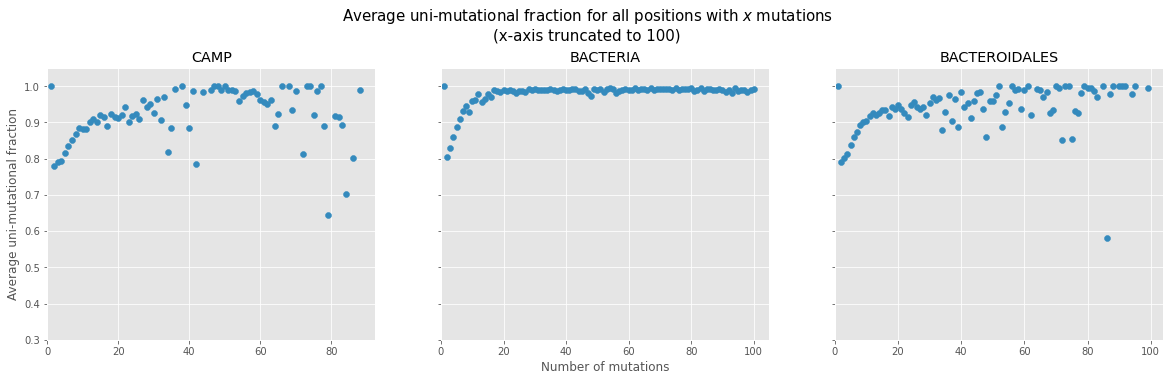

In [5]:
fig, axes = pyplot.subplots(1, 3, sharey=True)

xlim_max = 100
for col, seq in enumerate(SEQS):
    n2a = get_all_mutation_profile_data(seq)["num_mutations_to_avg_unimutational_fraction"]
    
    for i in range(0, xlim_max + 1):
        if type(n2a[i]) != str:
            axes[col].scatter(i, n2a[i], c=SCATTERPLOT_PT_COLOR)

    if col == 1:
        axes[col].set_xlabel("Number of mutations")
    if col == 0:
        axes[col].set_ylabel("Average uni-mutational fraction")
    axes[col].set_xlim(0)
    axes[col].set_ylim(0.3, 1.05)
    axes[col].set_title(seq2name[seq])
    
fig.suptitle(
    "Average uni-mutational fraction for all positions with $x$ mutations\n(x-axis truncated to {})".format(xlim_max),
    fontsize="15",
    y=1.05
)
fig.set_size_inches(20, 5)
fig.savefig("figs/avg-unimut-mutation-profiles.png", bbox_inches="tight")

### Plot mutation profiles with # mutations against # uni-mutational positions

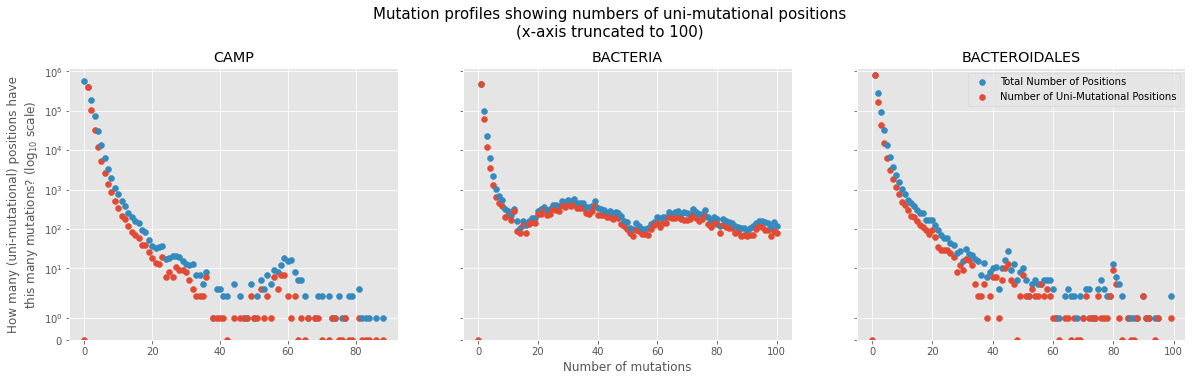

In [6]:
# two poss variants of these, one with an x-max of 100 (to focus on "low" numbers of mutations)
# and another with no x-max. for now we're just doing the 100 one, but could tile both like in the mutation
# profiles fig if desired -- use the for loop below to get that started
#
# for xmax in [100, None]:
xmax = 100
fig, axes = pyplot.subplots(1, 3, sharey=True)

for col, seq in enumerate(SEQS):
    data = get_all_mutation_profile_data(seq)

    largest_mutct = max(data["num_mutations_to_freq"].keys()) if xmax is None else xmax
    for i in range(0, largest_mutct + 1):
        # Only plot #s of mutations with at least one occurrence
        if data["num_mutations_to_freq"][i] > 0:
            axes[col].scatter(i, data["num_mutations_to_freq"][i], c=SCATTERPLOT_PT_COLOR,
                           label="" if i > 0 else "Total Number of Positions")
            axes[col].scatter(i, data["num_mutations_to_unimutational_pos_ct"][i], c="#e24a33",
                           label="" if i > 0 else "Number of Uni-Mutational Positions")

    # Need to use symlog in order to be kosher with zeroes
    axes[col].set_yscale("symlog")
    axes[col].set_ylim(0)

    # only set xlabel for middlest plot
    if col == 1:
        axes[col].set_xlabel("Number of mutations")        
    ylabel = "How many (uni-mutational) positions have\nthis many mutations?"
    ylabel += " (log$_{10}$ scale)"
    
    # only set ylabel for leftmost plot
    if col == 0:
        axes[col].set_ylabel(ylabel)

#     title = "{}: Mutation profile".format(seq2name[seq])
#     if xmax is not None: title += "\n(x-axis truncated to {})".format(xmax)
    axes[col].set_title(seq2name[seq])
    
    # only set legend for rightmost plot
    if col == 2:
        axes[col].legend()

fig.suptitle(
    "Mutation profiles showing numbers of uni-mutational positions\n(x-axis truncated to {})".format(xlim_max),
    fontsize="15",
    y=1.05
)
fig.set_size_inches(20, 5)
fig.savefig("figs/num-unimut-pos-mutation-profiles.png", bbox_inches="tight")